
<br>
    This file used to load the entire dataset, perform the require preprocessing and split the data into train, validation and test sets<br>


In [16]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow.keras as K
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import img_to_array

import pandas as pd

In [3]:
import tensorflow as tf

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
import os

dataset_dir = '../../acne_images/'

# Get the list of all entries in the directory
entries = os.listdir(dataset_dir)

# Filter out only the directories
folders = [entry for entry in entries if os.path.isdir(os.path.join(dataset_dir, entry))]

print(folders)

['comedones', 'cysts', 'nodules', 'papules', 'pustules']


In [19]:
import os
import pandas as pd

# Define the directory containing the image folders
dataset_dir = '../../acne_images/'

# Define the labels as folder names
labels = ['comedones', 'cysts', 'nodules', 'papules', 'pustules']

# Create a dictionary to hold the image names and their associated label binary indicators
image_labels = {}

# Iterate over each label (folder)
for label in labels:
    folder_path = os.path.join(dataset_dir, label)
    
    # Check if the folder exists
    if not os.path.exists(folder_path):
        continue
    
    # Get the list of images in the current folder
    images = os.listdir(folder_path)
    
    # Iterate over each image
    for image in images:
        image_path = os.path.join(folder_path, image)
        
        # Ensure it's a file (and not a directory)
        if os.path.isfile(image_path):
            # If the image is already in the dictionary, update the current label to 1
            if image in image_labels:
                image_labels[image][label] = 1
            else:
                # Otherwise, create a new entry for the image with all labels initialized to 0
                image_labels[image] = {lbl: 0 for lbl in labels}
                image_labels[image][label] = 1

# Convert the dictionary into a DataFrame
image_labels_df = pd.DataFrame([
    {"image_name": image, **label_dict}
    for image, label_dict in image_labels.items()
])

# Save the DataFrame to a CSV file
output_csv_path = 'image_labels.csv'
image_labels_df.to_csv(output_csv_path, index=False)

print(f"CSV file created: {output_csv_path}")


CSV file created: image_labels.csv


Label Counts:
 comedones    294
cysts        125
nodules      140
papules      341
pustules     342
dtype: int64


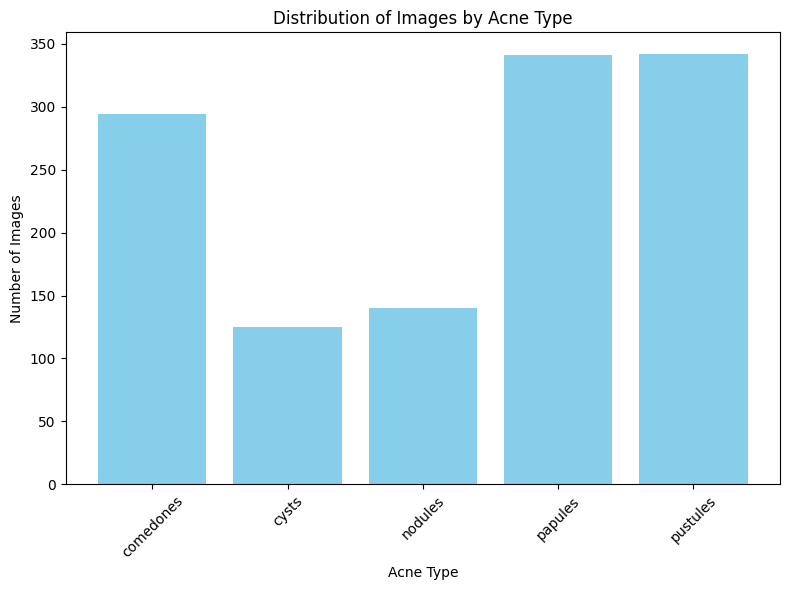

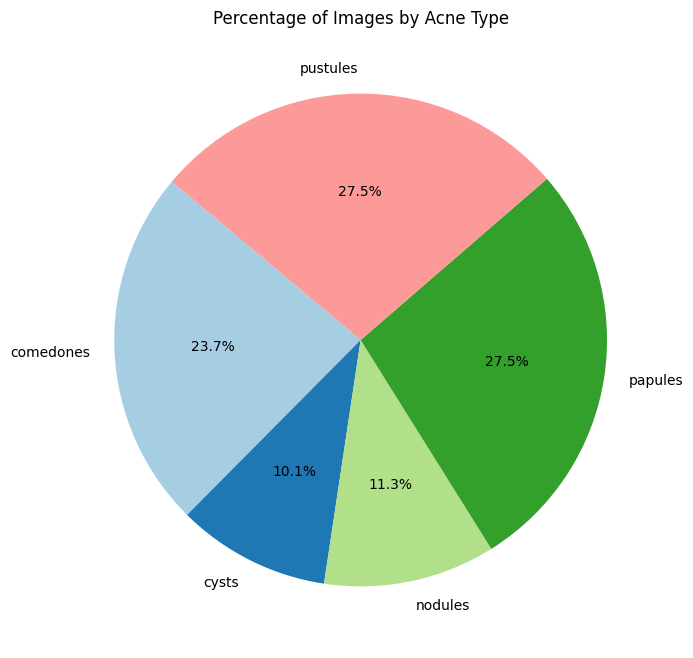

(950, 5)

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../../acne_image_multi_label/image_labels.csv'
image_labels_df = pd.read_csv(csv_file_path)

# Count the number of images for each label
label_counts = image_labels_df.iloc[:, 1:].sum()

# Print the counts to verify
print("Label Counts:\n", label_counts)

# Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Acne Type')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Acne Type')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Percentage of Images by Acne Type')
plt.show()

targets = np.array(image_labels_df.iloc[:, 1:])
targets

In [71]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the dataset directory and processed images directory
dataset_dir = '../../acne_image_multi_label/'
processed_images_dir = dataset_dir

# Define the labels as folder names
labels = ['comedones', 'cysts', 'nodules', 'papules', 'pustules']

# Create directories for 'nodules' and 'cysts' if they don't exist
nodules_dir = os.path.join(dataset_dir, 'nodules')
cysts_dir = os.path.join(dataset_dir, 'cysts')

for dir_path in [nodules_dir, cysts_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Load the CSV file
csv_file_path = '../../acne_image_multi_label/image_labels.csv'
image_labels_df = pd.read_csv(csv_file_path)

# Identify images exclusively belonging to 'nodules' or 'cysts'
nodules_images = image_labels_df[
    (image_labels_df['nodules'] == 1) &
    (image_labels_df['cysts'] == 0) &
    (image_labels_df['comedones'] == 0) &
    (image_labels_df['papules'] == 0) &
    (image_labels_df['pustules'] == 0)
]

cysts_images = image_labels_df[
    (image_labels_df['cysts'] == 1) &
    (image_labels_df['nodules'] == 0) &
    (image_labels_df['comedones'] == 0) &
    (image_labels_df['papules'] == 0) &
    (image_labels_df['pustules'] == 0)
]

# Calculate how many images to generate for balancing (set to 200 for both classes)
target_count = 200
nodules_to_augment = max(0, target_count - len(nodules_images))
cysts_to_augment = max(0, target_count - len(cysts_images))

print(f"Augmenting {nodules_to_augment} 'nodules' images and {cysts_to_augment} 'cysts' images.")

# ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images
def augment_images(image_names, target_dir, count):
    augmented_images = []
    
    for image_name in image_names:
        image_path = os.path.join(processed_images_dir, image_name)
        if not os.path.isfile(image_path):
            print(f"Image not found: {image_path}")
            continue
            
        image = Image.open(image_path).convert('RGB')
        image_array = np.array(image)

        # Create a batch of one image (required for ImageDataGenerator)
        image_array = np.expand_dims(image_array, axis=0)

        # Generate augmented images
        for i in range(count // len(image_names) + 1):
            augmented_iterator = datagen.flow(image_array, batch_size=1)

            # Generate one augmented image
            augmented_image = next(augmented_iterator)[0].astype(np.uint8)
            augmented_image = Image.fromarray(augmented_image)

            # Create a unique name for the augmented image
            augmented_image_name = f"{os.path.splitext(image_name)[0]}_aug_{i}.jpg"
            augmented_image_path = os.path.join(target_dir, augmented_image_name)

            # Save the augmented image
            augmented_image.save(augmented_image_path)

            # Add to list of augmented images
            augmented_images.append(augmented_image_name)

    # Return the names of the augmented images
    return augmented_images

# Augment nodules and cysts images
nodules_augmented_images = augment_images(nodules_images['image_name'], nodules_dir, nodules_to_augment)
cysts_augmented_images = augment_images(cysts_images['image_name'], cysts_dir, cysts_to_augment)

# Prepare new labels for augmented images
def create_augmented_labels(image_names, label_index):
    new_labels = []
    for image_name in image_names:
        label_array = [0] * len(labels)
        label_array[label_index] = 1
        new_labels.append((image_name, *label_array))
    return new_labels

# Generate new label entries
new_nodules_labels = create_augmented_labels(nodules_augmented_images, labels.index('nodules'))
new_cysts_labels = create_augmented_labels(cysts_augmented_images, labels.index('cysts'))

# Convert lists to DataFrame
augmented_labels_df = pd.DataFrame(new_nodules_labels + new_cysts_labels, columns=['image_name'] + labels)

# Append the new entries to the original DataFrame
updated_image_labels_df = pd.concat([image_labels_df, augmented_labels_df])

# Save updated labels to CSV
updated_csv_file_path = os.path.join(dataset_dir, 'updated_image_labels.csv')
updated_image_labels_df.to_csv(updated_csv_file_path, index=False)

# Print summary
print(f"Augmented images and updated labels saved. Total images: {len(updated_image_labels_df)}.")


Augmenting 143 'nodules' images and 154 'cysts' images.
Augmented images and updated labels saved. Total images: 1305.


Label Counts:
 comedones    294
cysts        309
nodules      311
papules      341
pustules     342
dtype: int64


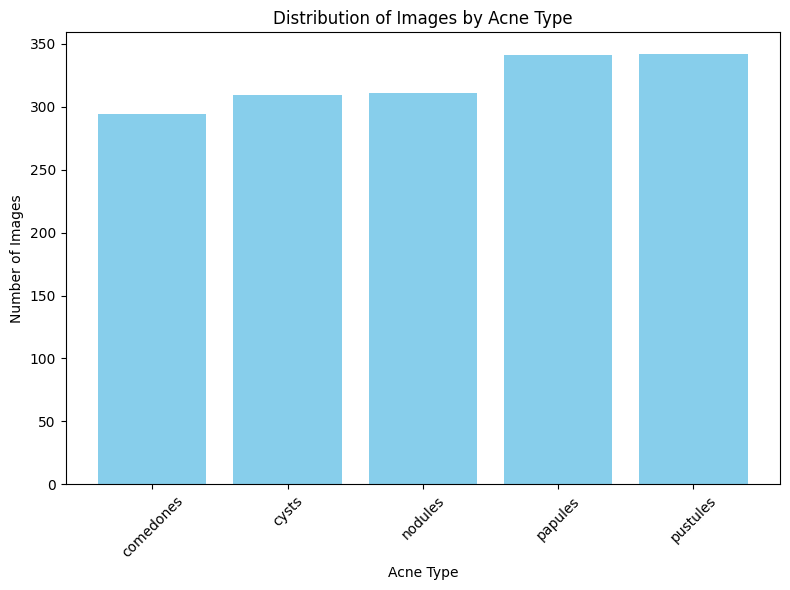

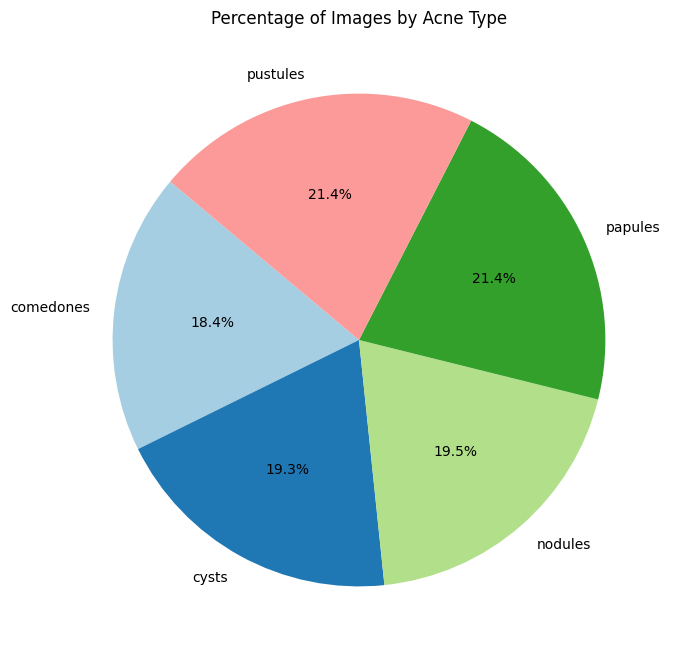

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=int64)

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../../acne_image_multi_label/updated_image_labels.csv'
updated_image_labels_df = pd.read_csv(csv_file_path)

# Count the number of images for each label
label_counts = updated_image_labels_df.iloc[:, 1:].sum()

# Print the counts to verify
print("Label Counts:\n", label_counts)

# Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Acne Type')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Acne Type')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Percentage of Images by Acne Type')
plt.show()

targets = np.array(image_labels_df.iloc[:, 1:])
targets

In [74]:
updated_image_labels_df.shape

(1302, 6)

In [81]:
import pandas as pd
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import os

# Load the updated CSV file with augmented images
dataset_dir = '../../acne_image_multi_label/'
updated_csv_file_path = os.path.join(dataset_dir, 'updated_image_labels.csv')
updated_image_labels_df = pd.read_csv(updated_csv_file_path)

# Extract features and multilabel targets
X = updated_image_labels_df.drop(columns=['comedones', 'cysts', 'nodules', 'papules', 'pustules']).values
y = updated_image_labels_df[['comedones', 'cysts', 'nodules', 'papules', 'pustules']].values

# Perform iterative stratified split for multilabel data
X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.2)
X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

# Convert arrays back to DataFrames
train_df = pd.DataFrame(np.hstack((X_train, y_train)), columns=updated_image_labels_df.columns)
val_df = pd.DataFrame(np.hstack((X_val, y_val)), columns=updated_image_labels_df.columns)
test_df = pd.DataFrame(np.hstack((X_test, y_test)), columns=updated_image_labels_df.columns)

# Save the splits into separate CSV files
train_csv_path = os.path.join(dataset_dir, 'train_image_labels.csv')
val_csv_path = os.path.join(dataset_dir, 'val_image_labels.csv')
test_csv_path = os.path.join(dataset_dir, 'test_image_labels.csv')

train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

# Print summary
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 1040
Validation set size: 129
Test set size: 133


In [85]:
train_df

,image_name,comedones,cysts,nodules,papules,pustules
0,2 (53)1 - Copy.jpg,1,0,0,0,0
1,34_jpeg_jpg.rf.0adac2e488226fb2f0f8b5758f839c6...,1,0,0,0,0
2,360_F_76033410_rJoKiNewoRuSzxXkALKr6bbYwl2U39D...,1,0,0,0,0
3,Acne (143).jpg,1,0,0,1,0
4,acne-black-spots-and-scars-on-forehead.jpg,1,0,0,0,0
...,...,...,...,...,...,...
1035,set2---30-_jpg.rf.fc8d373d20fba5997ee498e59872...,0,1,0,0,0
1036,shutterstock_2223729759_jpg.rf.15d340497bb97e2...,0,1,0,0,0
1037,shutterstock_2223729759_jpg.rf.15d340497bb97e2...,0,1,0,0,0
1038,shutterstock_2223729759_jpg.rf.15d340497bb97e2...,0,1,0,0,0


### Visualizing train dataset split

Label Counts:
 comedones    235
cysts        247
nodules      249
papules      273
pustules     274
dtype: int64


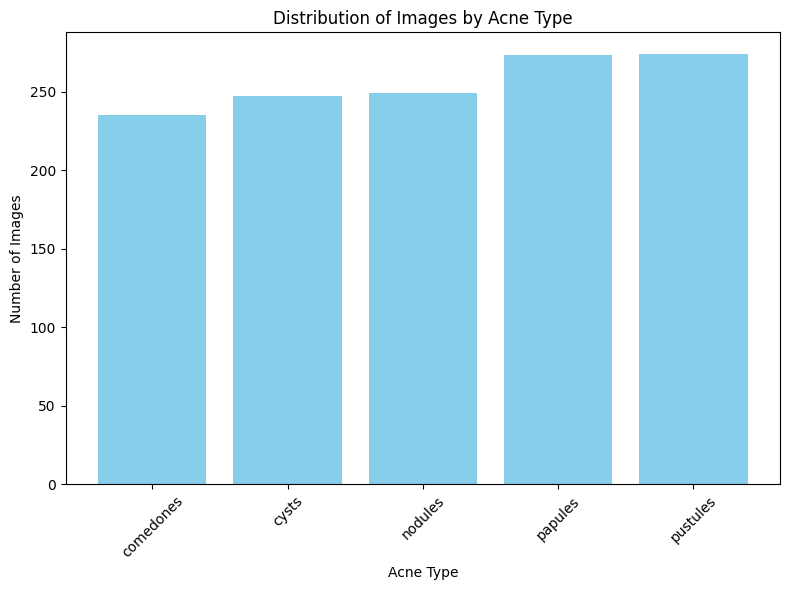

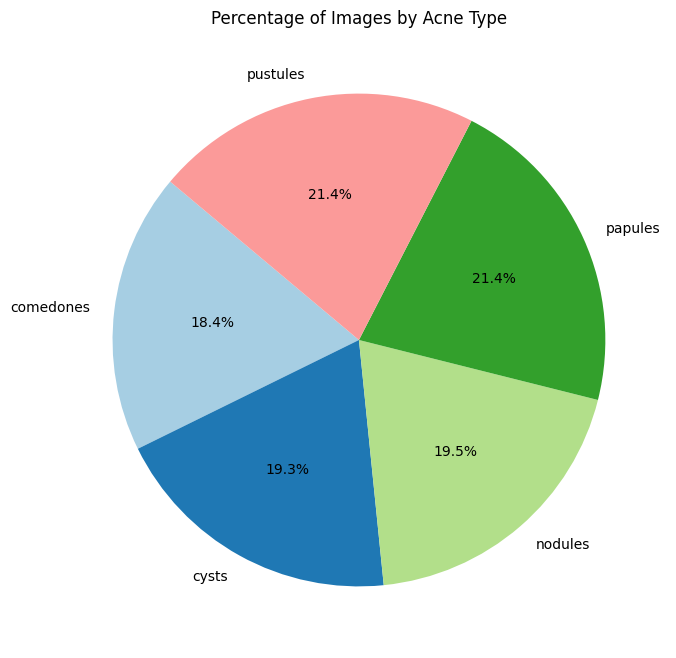

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=int64)

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
train_file_path = '../../acne_image_multi_label/train_image_labels.csv'
train_image_labels_df = pd.read_csv(train_file_path)

# Count the number of images for each label
label_counts = train_image_labels_df.iloc[:, 1:].sum()

# Print the counts to verify
print("Label Counts:\n", label_counts)

# Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Acne Type')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Acne Type')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Percentage of Images by Acne Type')
plt.show()

targets = np.array(image_labels_df.iloc[:, 1:])
targets

In [5]:
features = []
labels = []

# Loop over the directories
for label in tqdm(label_dict.keys()):
    # Get the list of all files in directory
    img_list = glob.glob(os.path.join(dataset_dir, label, '*')) 
    
    # Loop over the images
    for img_path in img_list:
        try:
            img = image.load_img(img_path, target_size=(299, 299))
            x = img_to_array(img)        
            x = xception.preprocess_input(x)
        
            features.append(x)
            labels.append(label_dict[label])
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")


 20%|████████████████▊                                                                   | 1/5 [00:04<00:17,  4.33s/it]

Error processing image ../../acne_images/cysts\desktop.ini: cannot identify image file <_io.BytesIO object at 0x00000200EA7C7DD0>


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:08<00:04,  2.37s/it]

Error processing image ../../acne_images/papules\desktop.ini: cannot identify image file <_io.BytesIO object at 0x00000200EA7FCA90>


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:10<00:02,  2.39s/it]

Error processing image ../../acne_images/pustules\desktop.ini: cannot identify image file <_io.BytesIO object at 0x00000200D89AEBB0>


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.80s/it]


The K.applications.xception.preprocess_input(x) function is part of the Keras library and is used to preprocess input for the Xception model.

The Xception model, like other pre-trained models in Keras, expects input in a specific format. The preprocess_input function is used to transform the input data into this format.

Here’s what the preprocess_input function does for the Xception model:

It scales the pixel values in the input image to a range of -1 to 1. This is a common preprocessing step for neural network inputs, as it can help the model learn more effectively.
So, when you see x = K.applications.xception.preprocess_input(x), it means the input data x is being preprocessed so it can be used as input to the Xception model.